In [1]:
import os
import numpy as np
import transformers
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from eval import *
from transformers import default_data_collator
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

dir_path = "/data/NFS/andy/course/ADL/hw2/"
data_path = dir_path + "/dataset/train.json"
context_path = dir_path + "/dataset/context.json"
weights_path = dir_path + "/qa_weigths/"

# model_checkpoint = "bert-base-chinese"
# model_checkpoint = "hfl/chinese-roberta-wwm-ext"
model_checkpoint = "hfl/chinese-macbert-large"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
squad_v2 = False

In [2]:
def prepare_train_features(examples):
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

def prepare_validation_features(examples):
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [3]:
data = load_json(data_path)
context = load_json(context_path)

for i in range(len(data)):
    data[i]["answers"] = {"answer_start":[data[i]["answers"][0]["start"]], "text": [data[i]["answers"][0]["text"]]}
    
length = int(len(data)*0.8)
train_data = {"id":[], "question":[], "context":[], "answers":[]}
val_data = {"id":[], "question":[], "context":[], "answers":[]}
for sub in data[:length]:
    train_data["id"].append(sub["id"])
    train_data["question"].append(sub["question"])
    train_data["context"].append(context[sub["relevant"]])
    train_data["answers"].append(sub["answers"])
for sub in data[length:]:
    val_data["id"].append(sub["id"])
    val_data["question"].append(sub["question"])
    val_data["context"].append(context[sub["relevant"]])
    val_data["answers"].append(sub["answers"])
    
datasets = DatasetDict({"train":Dataset.from_dict(train_data), "val":Dataset.from_dict(val_data)})

[*] Loading /data/NFS/andy/course/ADL/hw2//dataset/train.json...done
[*] Loading /data/NFS/andy/course/ADL/hw2//dataset/context.json...done


In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_checkpoint)
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.
pad_on_right = tokenizer.padding_side == "right"

tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

In [5]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at hfl/chinese-macbert-large were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the

In [6]:
batch_size = 2
data_collator = default_data_collator

args = TrainingArguments(
    output_dir = "./qa_checkpoints",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps = 32,
    load_best_model_at_end = True,
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss
0,0.643900,0.357328
1,0.218300,0.348612
2,0.110900,0.455167


TrainOutput(global_step=1626, training_loss=0.3055918401457727, metrics={'train_runtime': 21631.7911, 'train_samples_per_second': 0.075, 'total_flos': 7.785702630376243e+16, 'epoch': 3.0})

In [8]:
trainer.save_model(weights_path)

In [9]:
validation_features = datasets["val"].map(prepare_validation_features, batched=True, 
                                          remove_columns=datasets["val"].column_names)

In [10]:
raw_predictions = trainer.predict(validation_features)

In [11]:
final_predictions = postprocess_qa_predictions(datasets["val"], validation_features, raw_predictions.predictions)

submission = {}
for i in range(len(datasets["val"])):
    submission[datasets["val"][i]["id"]] = final_predictions[datasets["val"][i]["id"]]

  0%|          | 9/4882 [00:00<01:00, 79.96it/s]

Post-processing 4882 example predictions split into 8659 features.


100%|██████████| 4882/4882 [01:07<00:00, 72.38it/s]


In [12]:
data = load_json(data_path)
length = int(len(data)*0.8)
data_val = data[length:]
answers = collect_answers(data_val)

[*] Loading /data/NFS/andy/course/ADL/hw2//dataset/train.json...done


In [13]:
tokenizer = Tokenizer()

In [14]:
result = compute_metrics(answers, submission, tokenizer)
pprint(result)

[*] Evaluating: 100%|██████████| 4882/4882 [00:58<00:00, 83.19it/s]

{'count': 4882, 'em': 0.865219172470299, 'f1': 0.9246757741238317}


In [15]:
def plot(train_metirc, val_metric, metric_name, loss=False):
    plt.plot(train_metirc, label='train_%s' %metric_name)
    plt.plot(val_metric, label="val_%s" %metric_name)
    plt.xlabel('epochs')
    plt.ylabel(metric_name)
    plt.xticks([0, 1, 2],[1, 2, 3])
    if loss:
        plt.legend(loc='upper right')
    else:
        plt.legend(loc='lower right')
    plt.show()

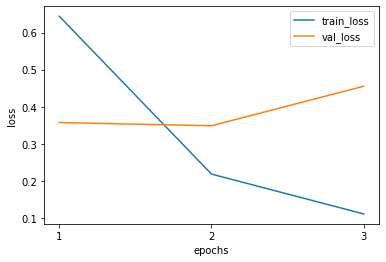

In [17]:
plot([0.643900, 0.218300, 0.110900], [0.357328, 0.348612, 0.455167], "loss", True)